# Pengerjaan Tugas UTS Deep Learning menggunakan TensorFlow (Klasifikasi Ikan)

# Persiapan: Instalasi library

In [1]:
%pip install numpy pandas matplotlib scikit-learn tensorflow


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Deep Learning dengan TensorFlow (MLP dan CNN)

## 1. Import Library yang Diperlukan

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings('ignore')

2025-04-29 23:44:26.846748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 23:44:26.861484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745945066.875356   36261 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745945066.879712   36261 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745945066.894321   36261 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## 2. Memuat Dataset Klasifikasi Ikan

Memeriksa dataset...


I0000 00:00:1745945068.502112   36261 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


File tidak valid: FishImgDataset/train/Silver Perch/silver perch (1).webp
File tidak valid: FishImgDataset/train/Silver Perch/silver perch (4).webp


2025-04-29 23:44:34.131007: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
2025-04-29 23:44:34.176331: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.


Direktori: FishImgDataset/train
Jumlah gambar valid: 8819
Jumlah gambar tidak valid: 2
Jenis ikan: ['Goby', 'Snakehead', 'Jaguar Gapote', 'Indian Carp', 'Climbing Perch', 'Indo-Pacific Tarpon', 'Catfish', 'Long-Snouted Pipefish', 'Tilapia', 'Mullet', 'Bangus', 'Pangasius', 'Gold Fish', 'Fourfinger Threadfin', 'Perch', 'Knifefish', 'Green Spotted Puffer', 'Silver Barb', 'Glass Perchlet', 'Janitor Fish', 'Black Spotted Barb', 'Silver Perch', 'Scat Fish', 'Mudfish', 'Grass Carp', 'Freshwater Eel', 'Silver Carp', 'Gourami', 'Tenpounder', 'Big Head Carp', 'Mosquito Fish']
--------------------------------------------------
Direktori: FishImgDataset/val
Jumlah gambar valid: 2751
Jumlah gambar tidak valid: 0
Jenis ikan: ['Goby', 'Snakehead', 'Jaguar Gapote', 'Indian Carp', 'Climbing Perch', 'Indo-Pacific Tarpon', 'Catfish', 'Long-Snouted Pipefish', 'Tilapia', 'Mullet', 'Bangus', 'Pangasius', 'Gold Fish', 'Fourfinger Threadfin', 'Perch', 'Knifefish', 'Green Spotted Puffer', 'Silver Barb', 'Glas

<Figure size 1400x800 with 0 Axes>

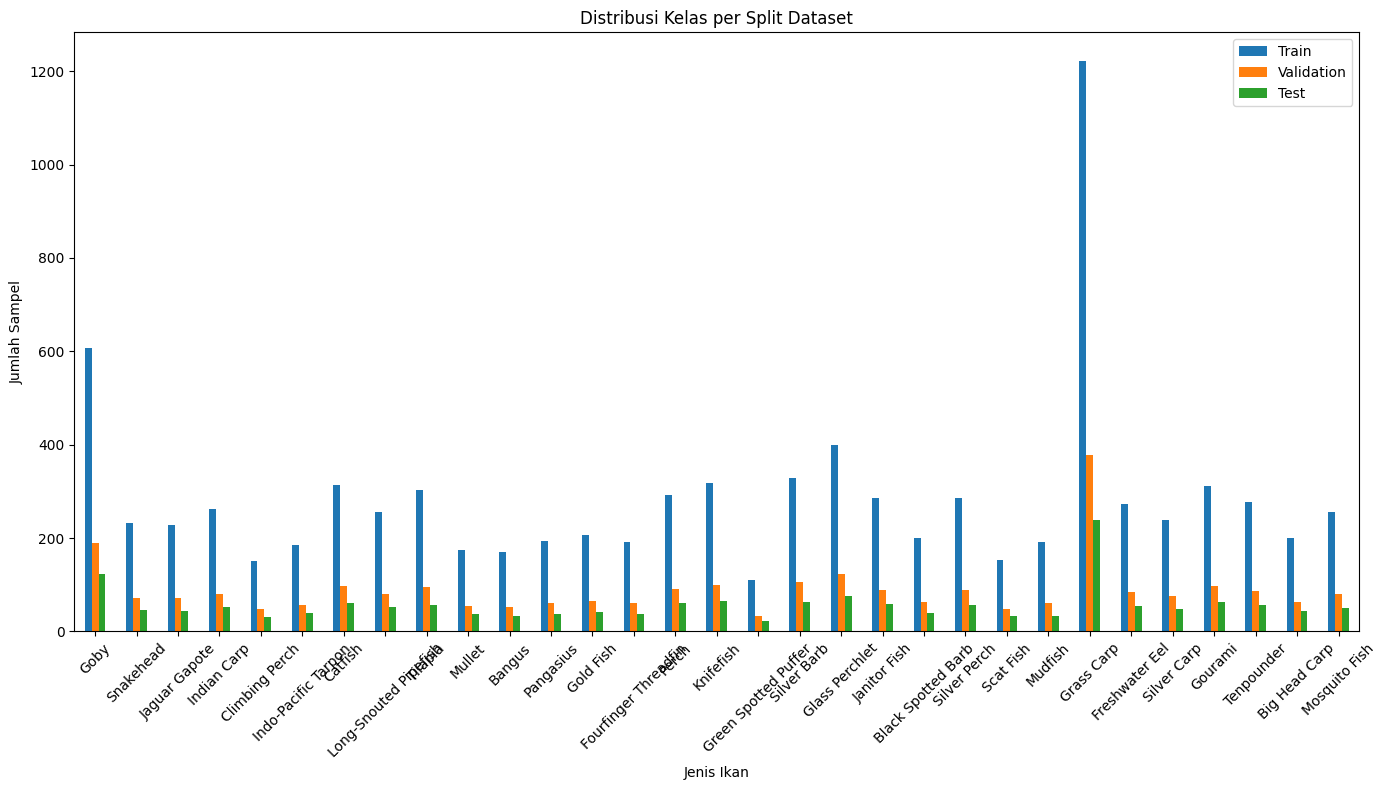

In [3]:
# Tentukan path dataset
dataset_path = 'FishImgDataset'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

# Fungsi untuk memeriksa keberadaan dan validitas gambar
def check_image_validity(directory):
    valid_images = 0
    invalid_images = 0
    fish_types = []
    
    for fish_type in os.listdir(directory):
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            fish_types.append(fish_type)
            for image_file in os.listdir(fish_dir):
                image_path = os.path.join(fish_dir, image_file)
                try:
                    img = tf.io.decode_image(tf.io.read_file(image_path))
                    valid_images += 1
                except:
                    invalid_images += 1
                    print(f"File tidak valid: {image_path}")
    
    print(f"Direktori: {directory}")
    print(f"Jumlah gambar valid: {valid_images}")
    print(f"Jumlah gambar tidak valid: {invalid_images}")
    print(f"Jenis ikan: {fish_types}")
    print("-" * 50)
    
    return fish_types

# Memeriksa validitas dataset
print("Memeriksa dataset...")
train_fish_types = check_image_validity(train_path)
val_fish_types = check_image_validity(val_path)
test_fish_types = check_image_validity(test_path)

# Membuat DataFrame untuk menghitung jumlah sampel per kelas
def get_class_distribution(directory, fish_types):
    distribution = {}
    for fish_type in fish_types:
        fish_dir = os.path.join(directory, fish_type)
        if os.path.isdir(fish_dir):
            count = len(os.listdir(fish_dir))
            distribution[fish_type] = count
    return distribution

train_distribution = get_class_distribution(train_path, train_fish_types)
val_distribution = get_class_distribution(val_path, val_fish_types)
test_distribution = get_class_distribution(test_path, test_fish_types)

# Membuat DataFrame untuk visualisasi distribusi kelas
df_distribution = pd.DataFrame({
    'Train': train_distribution,
    'Validation': val_distribution,
    'Test': test_distribution
})

print("Distribusi kelas per split dataset:")
print(df_distribution)

# Visualisasi distribusi kelas
plt.figure(figsize=(14, 8))
df_distribution.plot(kind='bar', figsize=(14, 8))
plt.title('Distribusi Kelas per Split Dataset')
plt.xlabel('Jenis Ikan')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fish_class_distribution.png')
plt.show()

# Viisualisasi 

## 3. Menyiapkan Fungsi Preprocessing

In [ ]:
# Konstanta untuk preprocessing
IMG_SIZE = 112  # Ukuran standar untuk banyak arsitektur CNN
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         
    width_shift_range=0.3,     
    height_shift_range=0.3,    
    shear_range=0.3,           
    zoom_range=0.3,            
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.3],  
    channel_shift_range=30,       
    fill_mode='reflect'           
)

# Hanya rescaling untuk validation dan test data
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator untuk training, validation, dan test
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Simpan informasi kelas
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)

print(f"Jumlah kelas: {num_classes}")
print(f"Nama kelas: {class_names}")
print(f"Mapping kelas: {class_indices}")


Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.
Jumlah kelas: 31
Nama kelas: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']
Mapping kelas: {'Bangus': 0, 'Big Head Carp': 1, 'Black Spotted Barb': 2, 'Catfish': 3, 'Climbing Perch': 4, 'Fourfinger Threadfin': 5, 'Freshwater Eel': 6, 'Glass Perchlet': 7, 'Goby': 8, 'Gold Fish': 9, 'Gourami': 10, 'Grass Carp': 11, 'Green Spotted Puffer': 12, 'Indian Carp': 13, 'Indo-Pacific Tarpon': 14, 'Jaguar Gapote': 15, 'Janitor Fish': 16, 'Knifefish': 1

## 4. Menampilkan Augmentasi dan Feature Engineering

Visualisasi augmentasi data...


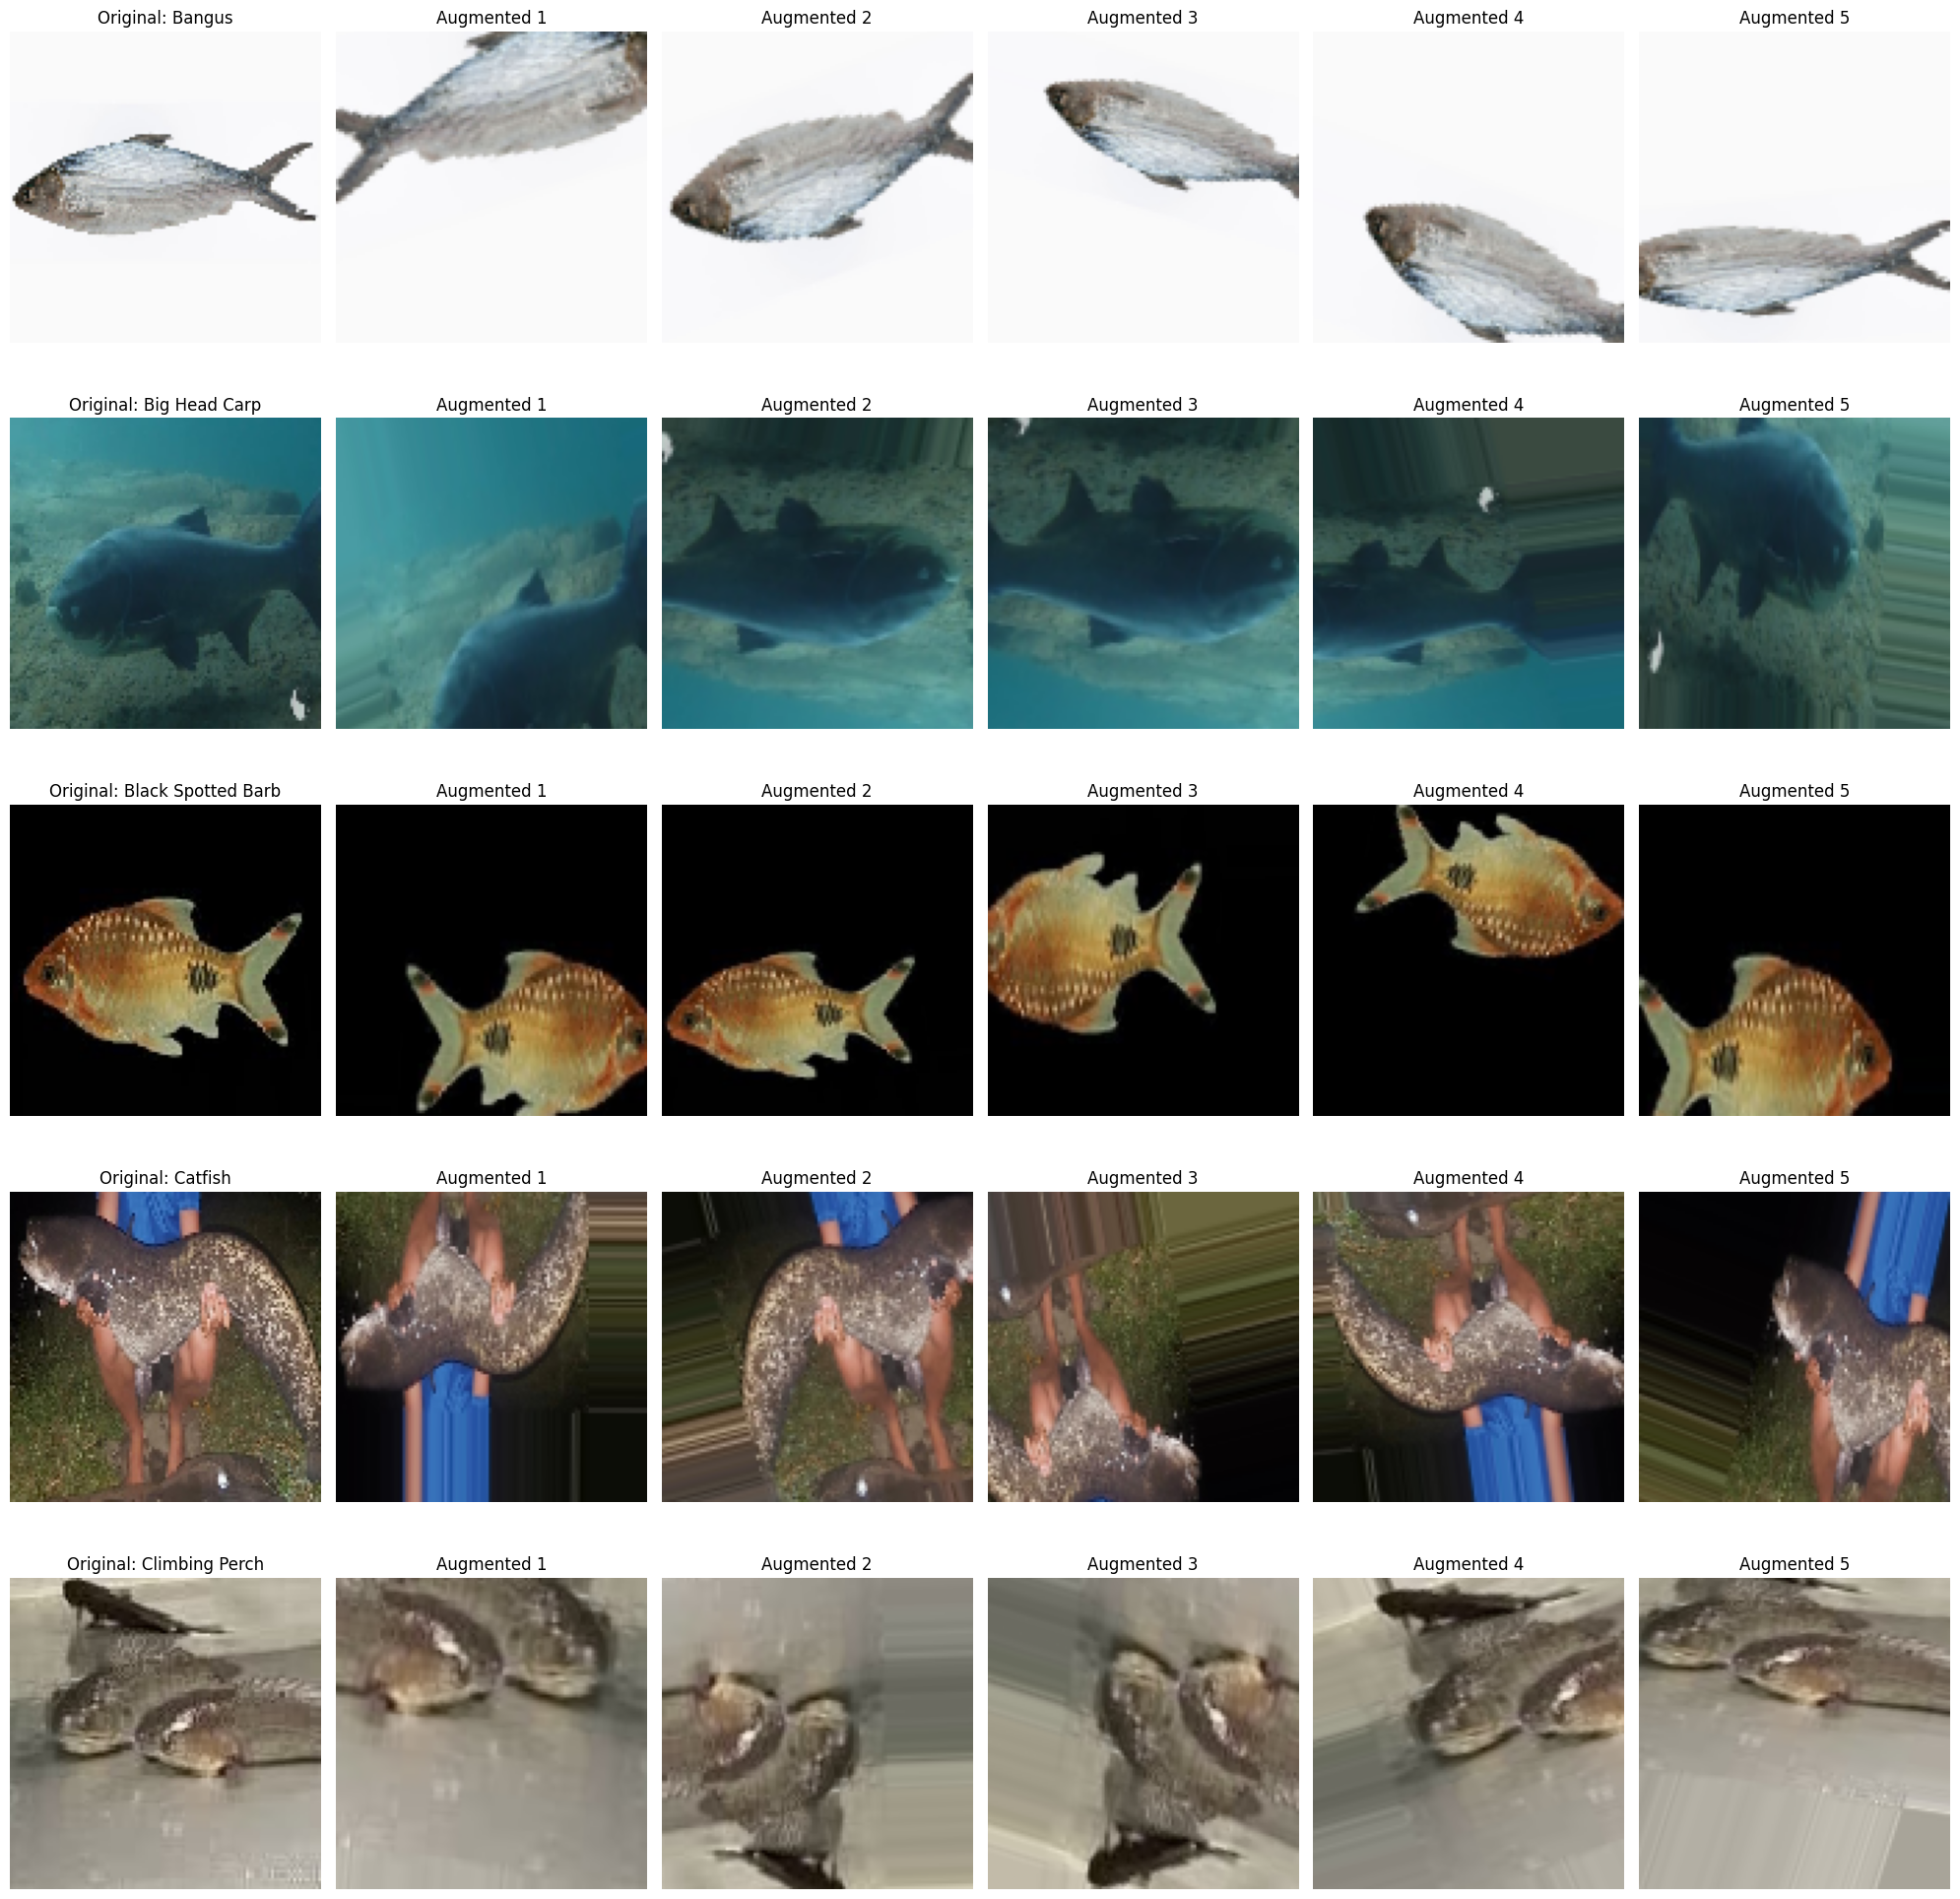

In [5]:
# Visualisasi beberapa contoh gambar dari dataset beserta augmentasi
def visualize_augmentation(datagen, dataset_path, class_names, num_samples=5):
    plt.figure(figsize=(20, 20))
    for i, fish_type in enumerate(class_names[:min(5, len(class_names))]):
        sample_dir = os.path.join(dataset_path, fish_type)
        if os.path.isdir(sample_dir):
            sample_files = os.listdir(sample_dir)[:1]  # Ambil 1 gambar per kelas
            for j, file in enumerate(sample_files):
                img_path = os.path.join(sample_dir, file)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)
                
                # Visualisasi gambar asli
                plt.subplot(len(class_names[:min(5, len(class_names))]), 
                            num_samples + 1, 
                            i * (num_samples + 1) + 1)
                plt.imshow(img)
                plt.title(f"Original: {fish_type}")
                plt.axis('off')
                
                # Visualisasi augmentasi
                augm_iterator = datagen.flow(x, batch_size=1)
                for k in range(num_samples):
                    augm_img = next(augm_iterator)[0]
                    plt.subplot(len(class_names[:min(5, len(class_names))]), 
                                num_samples + 1, 
                                i * (num_samples + 1) + k + 2)
                    plt.imshow(augm_img)
                    plt.title(f"Augmented {k+1}")
                    plt.axis('off')
                break
    
    plt.tight_layout()
    plt.savefig('data_augmentation_samples.png')
    plt.show()

print("Visualisasi augmentasi data...")
visualize_augmentation(train_datagen, train_path, class_names)

## 5. Menyiapkan Fungsi Evaluasi

In [32]:
def evaluate_metrics(y_true, y_pred, y_prob, num_classes=num_classes):
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=num_classes)
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro', multi_class='ovr')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score
    }

## 6. Menyiapkan Fungsi Visualisasi untuk Evaluasi

In [45]:
def visualize_results(history):
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Fungsi untuk menampilkan ROC curve
def visualize_roc_curve(y_true, y_scores):
    # Binarize the output
    n_classes = y_scores.shape[1]
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for a specific class (e.g., class 1)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr[1], tpr[1], label=f'ROC curve (area = {roc_auc[1]:.2f})')  # Example: Plotting for class 1
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10)) # Increase figure size
    plt.matshow(cm, cmap='Blues', fignum=1)
    plt.colorbar()
    plt.title('Confusion Matrix')
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')
            
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(num_classes), class_names, rotation=90, fontsize=8) # Rotate x-axis labels
    plt.yticks(range(num_classes), class_names, fontsize=8) # Adjust y-axis label font size
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()


## B. CNN CIFAR-10 Dengan Tensorflow

### 1. Penyusunan Model Neural Network


In [8]:
# Membuat model CNN
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):
    # Inisialisasi model
    model = Sequential([
        # Input Layer
        Input(shape=input_shape),

        # Blok Konvolusional 1
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 2
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Blok Konvolusional 3
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Inisialisasi model
model_cnn = create_cnn_model()

### 2. Kompilasi Model

In [9]:
# Kompilasi model
model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,152,319 (50.17 MB)

 Trainable params: 13,150,399 (50.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

### 3. Pelatihan Model

In [ ]:
# Callbacks untuk optimasi training
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('model_fish_classification.keras', save_best_only=True)
]

# Menghitung steps per epoch
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

# Training model
print("Melatih model CNN...")
history = model_cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Melatih model CNN...
Epoch 1/50


I0000 00:00:1745945095.807438   36365 service.cc:152] XLA service 0x7efc700028d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745945095.807468   36365 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-29 23:44:55.864662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745945096.214824   36365 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-29 23:44:56.942083: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[16,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,112,112]{3,2,1,0} %bitcast.16237, f32[32,3,3,3]{3,2,1,0} %bitcast.16244, f32[32]{0} %bitcast.17882), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_tar

  1/551 ━━━━━━━━━━━━━━━━━━━━ 1:30:32 10s/step - accuracy: 0.0625 - loss: 5.5679

I0000 00:00:1745945103.258511   36365 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/551 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.1138 - loss: 4.2002

2025-04-29 23:45:10.108450: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.22 = (f32[1,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,28,28]{3,2,1,0} %bitcast.18903, f32[128,64,3,3]{3,2,1,0} %bitcast.16714, f32[128]{0} %bitcast.18963), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_4_1/convolution" source_file="/home/husain/dlvenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-29 23:45:10.195346: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted 

550/551 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1202 - loss: 3.9884

2025-04-29 23:45:35.094615: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[16,32,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,112,112]{3,2,1,0} %bitcast.918, f32[32,3,3,3]{3,2,1,0} %bitcast.925, f32[32]{0} %bitcast.927), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1/conv2d_1/convolution" source_file="/home/husain/dlvenv/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-29 23:45:35.229369: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potenti

551/551 ━━━━━━━━━━━━━━━━━━━━ 50s 72ms/step - accuracy: 0.1202 - loss: 3.9875 - val_accuracy: 0.2632 - val_loss: 2.7968 - learning_rate: 0.0010
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.1841 - loss: 3.2669 - val_accuracy: 0.2577 - val_loss: 2.9105 - learning_rate: 0.0010
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.2209 - loss: 2.9850 - val_accuracy: 0.2439 - val_loss: 3.1308 - learning_rate: 0.0010
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.2521 - loss: 2.7455 - val_accuracy: 0.2021 - val_loss: 3.2555 - learning_rate: 0.0010
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 57ms/step - accuracy: 0.2769 - loss: 2.6169 - val_accuracy: 0.2784 - val_loss: 3.3842 - learning_rate: 0.0010
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 32s 58ms/step - accuracy: 0.3073 - loss: 2.4875 - val_accuracy: 0.3275 - val_loss: 2.4434 - learning_rate: 0.0010
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 31s 57ms/step - accuracy: 0.3153 - loss: 2.4544

### 4. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [35]:
# Evaluasi model
test_loss, test_accuracy = model_cnn.evaluate(test_generator, verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")

# Konversi dataset untuk evaluasi metrik lengkap
y_test = []
y_pred = []
y_pred_proba = []

# Menghitung prediksi untuk semua data uji
for i in range(len(test_generator)):
    x_batch, y_batch = test_generator[i]
    y_test.extend(np.argmax(y_batch, axis=1))
    y_pred_prob = model_cnn.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(y_pred_prob, axis=1))
    y_pred_proba.extend(y_pred_prob)

# Mengonversi ke numpy array
y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Menghitung metrik evaluasi
results = evaluate_metrics(y_test, y_pred, y_pred_proba)

# Output metrik evaluasi
print("Hasil evaluasi:")
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"Precision: {results['precision']:.4f}")
print(f"Recall: {results['recall']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")
print(f"AUC: {results['auc']:.4f}")


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5038 - loss: 1.6761
Test accuracy: 0.5790
Hasil evaluasi:
Accuracy: 0.5790
Precision: 0.6069
Recall: 0.5790
F1 Score: 0.5703
AUC: 0.9524


### 5. Memvisualisasikan Prediksi dari model yang telah dilatih

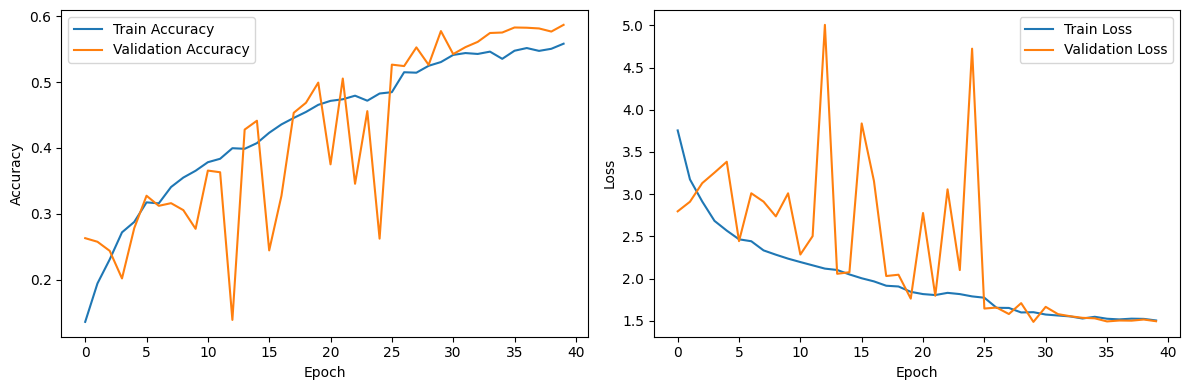

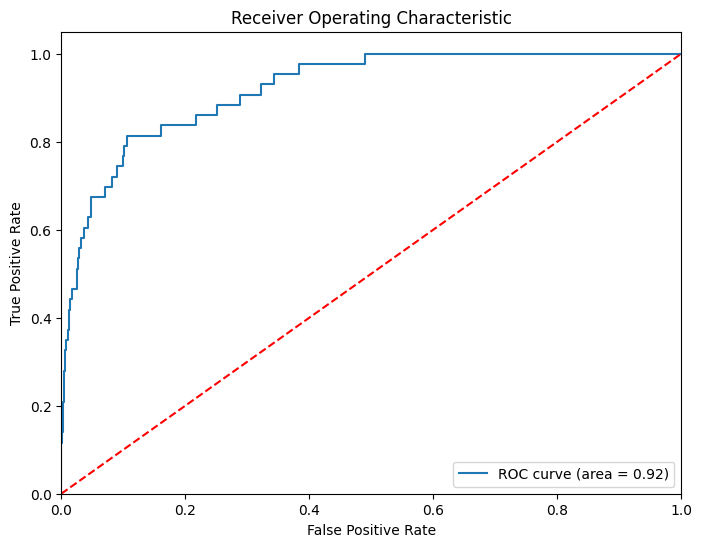

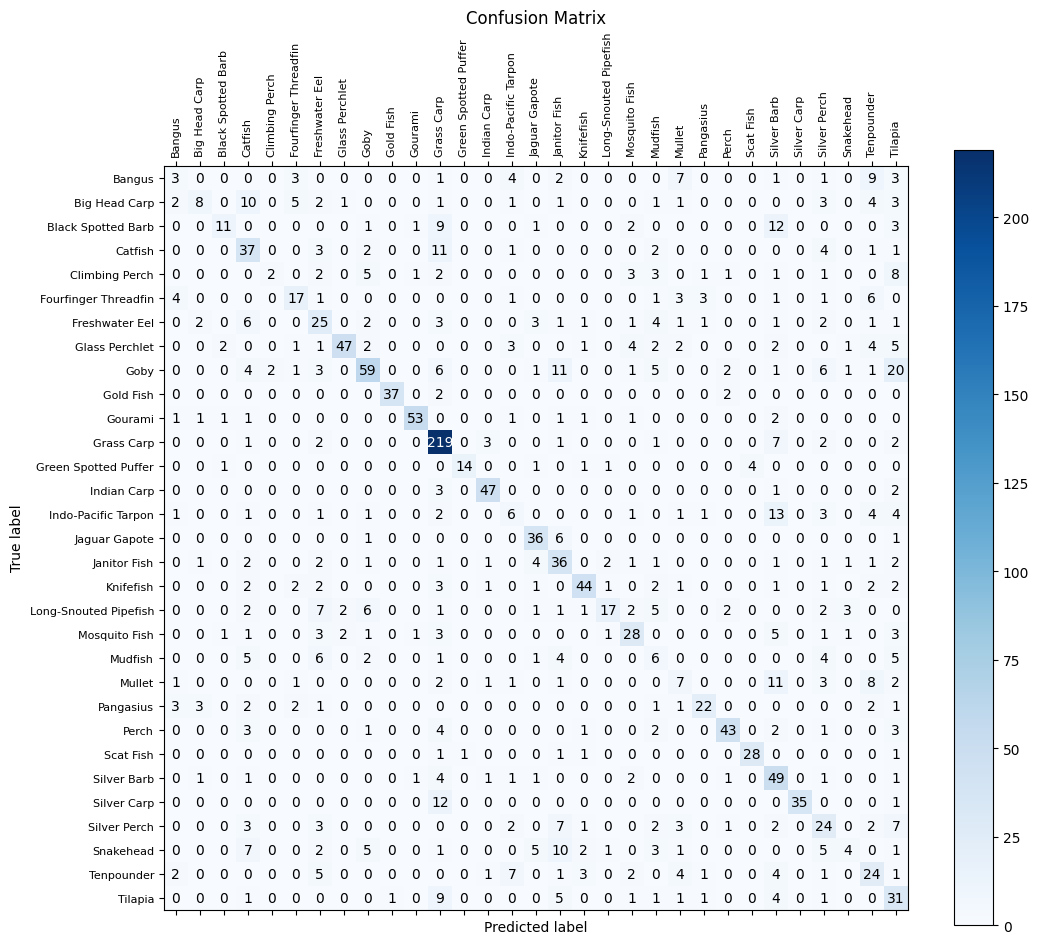

In [46]:
# Plot training history
visualize_results(history)

# Plot ROC curve (one vs rest untuk multi-kelas)
visualize_roc_curve(y_test, y_pred_proba)

# Plot confusion matrix
visualize_confusion_matrix(y_test, y_pred)

### 6. Menyimpan Model

In [47]:
# Menyimpan model
model_cnn.save('model_fish_classification.keras')
print("Model disimpan sebagai 'model_fish_classification.keras'")

Model disimpan sebagai 'model_fish_classification.keras'
